# Import libraries

In [2]:
import pandas as pd
import pandas_datareader as dr
import datetime
import statsmodels.api as sm
import seaborn as sns

import statsmodels

from matplotlib import rcParams
import matplotlib.pyplot as plt

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

# functions

In [3]:
def change_date(input):
    return datetime.date(int(str(input)[0:4]), int(str(input)[4:6]), int(str(input)[6:8]))

# Date preparation

In [4]:
# Rm-Rf includes all NYSE, AMEX, and NASDAQ firms. SMB, HML, RMW, and CMA for July of year t to June 
# of t+1 include all NYSE, AMEX, and NASDAQ stocks for which we have market equity data for December 
# of t-1 and June of t, (positive) book equity data for t-1 (for SMB, HML, and RMW), non-missing 
# revenues and at least one of the following: cost of goods sold, selling, general and administrative 
# expenses, or interest expense for t-1 (for SMB and RMW), and total assets data for t-2 and t-1 (for SMB and CMA).

df = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.CSV', skiprows=2)
df.rename(columns={'Unnamed: 0':'date'}, inplace=True)
df['date'] = df['date'].apply(change_date)
df.set_index('date', inplace = True)

# CBOE Volatility Index: VIX
# from fred

vix = dr.get_data_fred('VIXCLS', start='1990-01-02', end='2020-10-29')
vix.reset_index(inplace = True)
vix.rename(columns = {'VIXCLS':'vix', 'DATE':'date'}, inplace = True)
vix.set_index('date', inplace = True)

#merge dataframes
data = vix.merge(df,left_index=True, right_index= True)

In [5]:
data

,vix,Mkt-RF,SMB,HML,RMW,CMA,RF
date,,,,,,,
1990-01-02,17.24,1.44,-0.67,-0.06,0.20,-0.45,0.026
1990-01-03,18.19,-0.06,0.73,-0.31,0.16,-0.46,0.026
1990-01-04,19.22,-0.71,0.45,-0.25,-0.05,-0.02,0.026
1990-01-05,20.11,-0.85,0.74,-0.23,-0.01,-0.10,0.026
1990-01-08,20.26,0.30,-0.40,-0.24,0.06,0.31,0.026
...,...,...,...,...,...,...,...
2020-09-24,28.51,0.25,-0.20,0.32,0.49,0.11,0.000
2020-09-25,26.38,1.72,-0.16,-1.35,-0.50,-0.70,0.000
2020-09-28,26.19,1.66,0.86,1.03,0.36,0.19,0.000


In [6]:
ge = dr.get_data_yahoo('GE', start='1990-01-02', end='2020-10-29')

In [7]:
general_electric = ge[['Close', 'Volume']]

# Add return for General Electric

In [8]:
general_electric['return'] = 100*(general_electric['Close'] - general_electric.shift(1)['Close'])/general_electric.shift(1)['Close']

<ipython-input-8-6a299ff5a566>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general_electric['return'] = 100*(general_electric['Close'] - general_electric.shift(1)['Close'])/general_electric.shift(1)['Close']


In [9]:
general_electric 

,Close,Volume,return
Date,,,
1990-01-02,5.348557,22990600.0,NaN
1990-01-03,5.338542,20658100.0,-0.187265
1990-01-04,5.308494,18640100.0,-0.562848
1990-01-05,5.258413,19340200.0,-0.943399
1990-01-08,5.288462,15604900.0,0.571434
...,...,...,...
2020-10-23,7.630000,132563200.0,-1.165799
2020-10-26,7.380000,104254400.0,-3.276540
2020-10-27,7.100000,98170000.0,-3.794041


In [10]:
result = data.merge(general_electric['return'], left_index=True, right_index= True)

In [11]:
result.dropna(inplace=True)

In [12]:
X = result[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'vix']]
Y = result['return']
model = sm.OLS(Y,X)
results = model.fit(cov_type = 'HC1')

In [13]:
results.tvalues

Mkt-RF    38.884257
SMB       -4.829659
HML        7.711979
RMW        3.548436
CMA        0.135574
vix       -1.102359
dtype: float64

In [14]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                 return   R-squared (uncentered):                   0.501
Model:                            OLS   Adj. R-squared (uncentered):              0.501
Method:                 Least Squares   F-statistic:                              358.7
Date:                Mon, 02 Nov 2020   Prob (F-statistic):                        0.00
Time:                        19:06:08   Log-Likelihood:                         -13338.
No. Observations:                7744   AIC:                                  2.669e+04
Df Residuals:                    7738   BIC:                                  2.673e+04
Df Model:                           6                                                  
Covariance Type:                  HC1                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

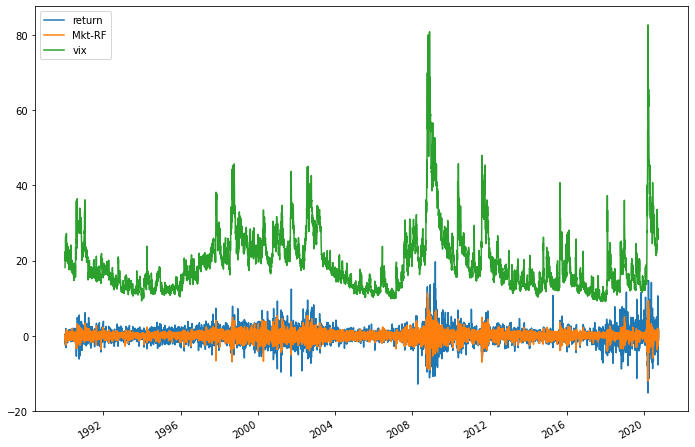

In [15]:
Y.plot()
X['Mkt-RF'].plot()
X['vix'].plot()

plt.legend(('return',  'Mkt-RF','vix'))

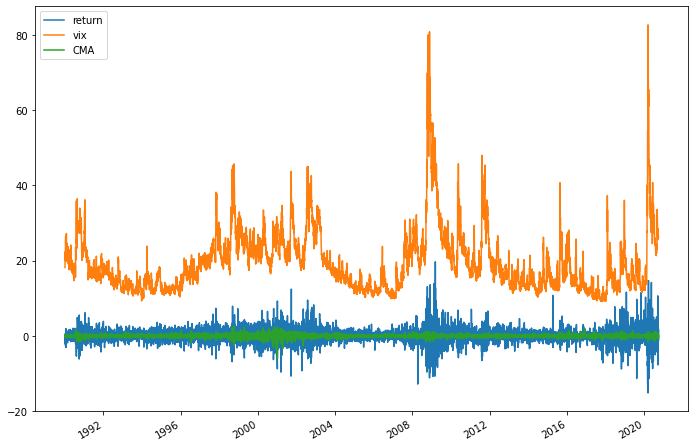

In [16]:
Y.plot()
X['vix'].plot()
X['CMA'].plot()
plt.legend(('return', 'vix', 'CMA'))

# S&P 500

In [17]:
sp = dr.get_data_yahoo('^GSPC', start='1990-01-02', end='2020-10-29')
standard_and_poor_500 = sp[['Close', 'Volume']]

In [19]:
standard_and_poor_500['return'] = 100*(standard_and_poor_500['Close'] - standard_and_poor_500.shift(1)['Close'])/standard_and_poor_500.shift(1)['Close']

<ipython-input-19-22280448ef86>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  standard_and_poor_500['return'] = 100*(standard_and_poor_500['Close'] - standard_and_poor_500.shift(1)['Close'])/standard_and_poor_500.shift(1)['Close']


## Regression OLS w/o vix

In [225]:
result = data.merge(standard_and_poor_500['return'], left_index=True, right_index= True)
result.dropna(inplace=True)
X = result[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
Y = result['return']
model = sm.OLS(Y,X)
results = model.fit(cov_type = 'HC1')
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                 return   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                          1.302e+05
Date:                Mon, 02 Nov 2020   Prob (F-statistic):                        0.00
Time:                        18:14:20   Log-Likelihood:                          8839.0
No. Observations:                7744   AIC:                                 -1.767e+04
Df Residuals:                    7739   BIC:                                 -1.763e+04
Df Model:                           5                                                  
Covariance Type:                  HC1                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

## Regression OLS with vix

In [213]:
result = data.merge(standard_and_poor_500['return'], left_index=True, right_index= True)
result.dropna(inplace=True)
X = result[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'vix']]
Y = result['return']
model = sm.OLS(Y,X)
results = model.fit(cov_type = 'HC1')
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                 return   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                          1.103e+05
Date:                Mon, 02 Nov 2020   Prob (F-statistic):                        0.00
Time:                        16:34:31   Log-Likelihood:                          8839.5
No. Observations:                7744   AIC:                                 -1.767e+04
Df Residuals:                    7738   BIC:                                 -1.763e+04
Df Model:                           6                                                  
Covariance Type:                  HC1                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

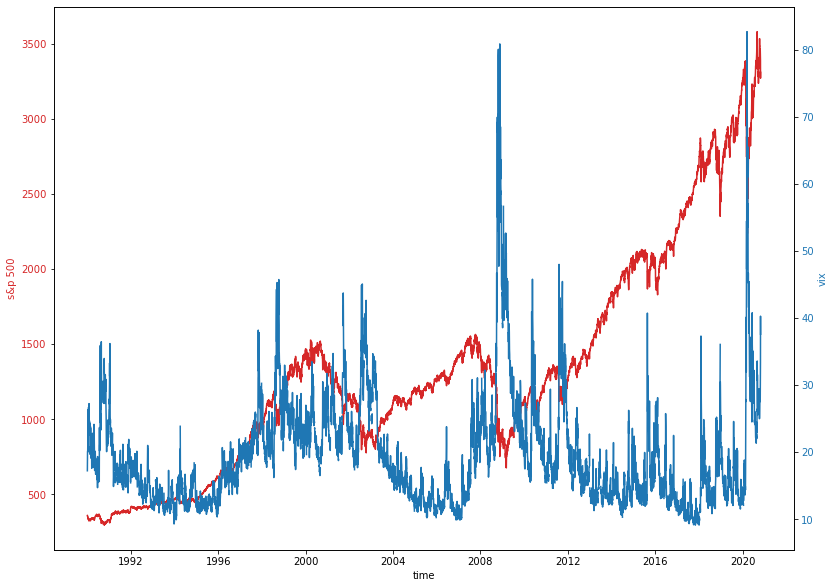

In [217]:
data1 = standard_and_poor_500['Close']
data2 = vix
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('s&p 500', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('vix', color=color)  # we already handled the x-label with ax1
ax2.plot(data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## experiment approach

In [18]:
standard_and_poor_500

,Close,Volume
Date,,
1990-01-02,359.690002,162070000
1990-01-03,358.760010,192330000
1990-01-04,355.670013,177000000
1990-01-05,352.200012,158530000
1990-01-08,353.790009,140110000
...,...,...
2020-10-23,3465.389893,3646570000
2020-10-26,3400.969971,3988080000
2020-10-27,3390.679932,3946990000


In [ ]:
standard_and_poor_500['return'] = 100*(standard_and_poor_500['Close'] - standard_and_poor_500.shift(1)['Close'])/standard_and_poor_500.shift(1)['Close']

In [23]:
data['vix_diff'] = (data['vix'] - 
                    data.shift(1)['vix'])/data.shift(1)['vix']

In [24]:
data

,vix,Mkt-RF,SMB,HML,RMW,CMA,RF,vix_diff
date,,,,,,,,
1990-01-02,17.24,1.44,-0.67,-0.06,0.20,-0.45,0.026,NaN
1990-01-03,18.19,-0.06,0.73,-0.31,0.16,-0.46,0.026,0.055104
1990-01-04,19.22,-0.71,0.45,-0.25,-0.05,-0.02,0.026,0.056625
1990-01-05,20.11,-0.85,0.74,-0.23,-0.01,-0.10,0.026,0.046306
1990-01-08,20.26,0.30,-0.40,-0.24,0.06,0.31,0.026,0.007459
...,...,...,...,...,...,...,...,...
2020-09-24,28.51,0.25,-0.20,0.32,0.49,0.11,0.000,-0.002449
2020-09-25,26.38,1.72,-0.16,-1.35,-0.50,-0.70,0.000,-0.074711
2020-09-28,26.19,1.66,0.86,1.03,0.36,0.19,0.000,-0.007202


In [27]:
result_diff = data.merge(standard_and_poor_500['return'], left_index=True, right_index= True)
result_diff.dropna(inplace=True)
result_diff.describe()

,vix,Mkt-RF,SMB,HML,RMW,CMA,RF,vix_diff,return
count,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000
mean,19.420532,0.033959,0.002555,0.003366,0.016831,0.007783,0.010408,0.002328,0.035311
std,8.120653,1.146909,0.584255,0.647082,0.458662,0.412482,0.008875,0.069437,1.149069
min,9.140000,-12.000000,-4.590000,-4.730000,-3.020000,-5.940000,0.000000,-0.295726,-11.984055
25%,13.630000,-0.440000,-0.330000,-0.290000,-0.200000,-0.200000,0.001000,-0.036761,-0.440382
50%,17.380000,0.070000,0.020000,-0.010000,0.010000,0.000000,0.009000,-0.003568,0.056598
75%,22.790000,0.550000,0.340000,0.270000,0.220000,0.200000,0.018000,0.032662,0.562247
max,82.690000,11.350000,5.710000,4.770000,4.490000,2.530000,0.034000,1.155979,11.580037


In [28]:
X = result_diff[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'vix_diff']]
Y = result_diff['return']
model = sm.OLS(Y,X)
results = model.fit(cov_type = 'HC1')
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                 return   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                          1.307e+05
Date:                Mon, 02 Nov 2020   Prob (F-statistic):                        0.00
Time:                        19:16:15   Log-Likelihood:                          8835.1
No. Observations:                7741   AIC:                                 -1.766e+04
Df Residuals:                    7735   BIC:                                 -1.762e+04
Df Model:                           6                                                  
Covariance Type:                  HC1                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------